# Lab1 Gradient Descent

# Import and Init Dataset

In [52]:
# Import
import configparser
import distutils.log
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [157]:
# Init data
df = pd.read_csv('D:\\学术资料\\硕士\\NYU\\DS-GA-1003\\Week1\\hw1\\hw1-sgd\\hw1-data.csv', delimiter=',')
X = df.values[:, :-1]
y = df.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=10)
X_train, X_test = feature_normalization(X_train, X_test)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))  # Add bias term

# Feature Normalization
only operate train dataset.
shift all data to ensure they are all larger than 0, then rescale them into [0,1]  
$X_{norm}=\frac{X-X{min}}{X_{max}\ \ \ \ -\ X_{min}}$
## Wanrning  
数据标准化必须以特征列为单位。不能所有数据共同标准化。因为不同feature的数据尺度不同。

In [156]:
def feature_normalization(train: np.ndarray, test: np.ndarray) -> [np.ndarray, np.ndarray]:
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """

    min_value: np.ndarray = np.min(train,axis=0)
    max_value: np.ndarray = np.max(train,axis=0)
    
    train_normalized = (train - min_value) / (max_value - min_value + 0.0)
    test_normalized = (test - min_value) / (max_value - min_value + 0.0)

    return train_normalized, test_normalized

# Compute Square Loss
Given a set of X, y, theta, compute the square loss for predicting y with X*theta   
loss func: $J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)^2$  
In matrix formulation, $h_{\theta}(x_i)=\theta ^{T}x_i$  
So $J(\theta)=\frac{1}{2m}(X\theta^{T}-y)(X\theta^{T}-y)^{T}$  


In [143]:
def compute_square_loss(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """

    num_instances = X.shape[0]
    auction = np.dot(X, theta)
    difference: np.ndarray = auction - y

    loss: float = 0.5 / num_instances * np.dot(difference, difference)
    return loss

# Compute Square Loss Gradient
$J(\theta)=\frac{1}{2m}(X\theta^{T})(X\theta^{T})^{T}$   
$\bigtriangledown\theta J(\theta)=\frac{1}{m}(X\theta^{T})X$

In [144]:
def compute_square_loss_gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """

    num_instances = X.shape[0]
    difference: np.ndarray = np.dot(X, theta) - y
    grad = 1.0 / (num_instances+0.0) * np.dot(X.transpose(), difference)
    return grad

# Gradient Check
Check that the function compute_square_loss_gradient returns the correct gradient for the given X, y, and theta.  
For all directions: let $e_1 = (1,0,0,\dots,0), e_2 = (0,1,0,\dots,0), \dots, e_d = (0,\dots,0,1)$  
Use approximation: $\frac{J(\theta + epsilon * e_i) - J(\theta - epsilon * e_i)}{(2*epsilon)}$ for each direction  
Then for each direction of gradient, check if Euclidean distance of approximation and computed is exceed tolerance(1e-4 default)  

In [102]:
def grad_checker(X: np.ndarray, y: np.ndarray, theta: np.ndarray, epsilon=0.01, tolerance=1e-4) -> bool:
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions:
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1)

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by:
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error

    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient: np.ndarray = compute_square_loss_gradient(X, y, theta)  # the true gradient
    num_features = theta.shape[0]
    approx_grad: np.ndarray = np.zeros(num_features)  # Initialize the gradient we approximate
    # TODO
    for index in range(num_features):
        e_i = np.zeros(num_features)
        e_i[index] = 1
        theta_plus = theta + epsilon * e_i
        theta_minus = theta - epsilon * e_i
        approx_grad[index] = \
            (compute_square_loss(X, y, theta_plus) - compute_square_loss(X, y, theta_minus)) \
            / (2 * epsilon)
    distance = np.linalg.norm(approx_grad-true_gradient)
    return distance < tolerance

# Generic Gradient Checker
Similar as Gradient Checker
The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned  
the true gradient for objective_func(X, y, theta).  
Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient  

In [26]:
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient: np.ndarray = gradient_func(X, y, theta)  # the true gradient
    num_features = theta.shape[0]
    approx_grad: np.ndarray = np.zeros(num_features)  # Initialize the gradient we approximate

    for index in range(num_features):
        e_i = np.zeros(num_features)
        e_i[index] = 1
        theta_plus = theta + epsilon * e_i
        theta_minus = theta - epsilon * e_i
        approx_grad[index] = \
            (objective_func(X, y, theta_plus) - objective_func(X, y, theta_minus)) \
            / (2 * epsilon)
    distance = np.linalg.norm(approx_grad - true_gradient)
    return distance < tolerance

# Batch Grad Descent  
每次迭代计算梯度，然后$\theta$下降一次梯度

In [122]:
def batch_grad_descent(X: np.ndarray, y: np.ndarray, step_size=0.1, num_iter=1000, check_gradient=False) \
        -> [np.ndarray, np.ndarray]:
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        step - step size in gradient descent
        num_iter - number of iterations to run
        check_gradient - a boolean value indicating whether checking the gradient when updating

    Returns:
        theta_hist - store the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features)
                    for instance, theta in iteration 0 should be theta_hist[0], theta in iteration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1)
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter + 1, num_features))  # Initialize theta_hist
    loss_hist = np.zeros(num_iter + 1)  # initialize loss_hist
    theta = np.ones(num_features)  # initialize theta
    # TODO
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)

    for iteration in range(1, num_iter + 1):
        if check_gradient:
            assert (grad_checker(X, y, theta) is True)
        grad = compute_square_loss_gradient(X, y, theta)
        theta = theta - step_size*grad.transpose()
        theta_hist[iteration] = theta
        loss = compute_square_loss(X, y, theta.transpose())
        loss_hist[iteration] = loss

    return theta_hist, loss_hist

## Draw Convergence Diagram
Try step sizes 0.5, 0.1, 0.05, 0.01. Plot the value of the objective function as a function of the number of steps for each step sizes. Briefly summarize your findings.

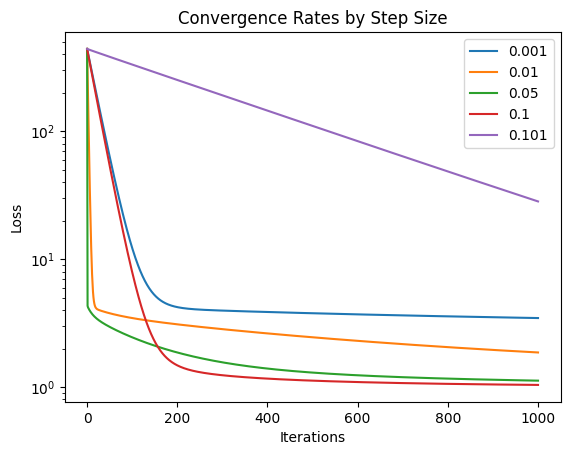

In [154]:
num_iter = 1000
def converge_test(X, y):
    step_sizes = np.array([0.001, 0.01, 0.05, 0.1, 0.101])
    for step_size in step_sizes:
        _, loss_hist = batch_grad_descent(X,y,step_size=step_size, num_iter=num_iter, check_gradient=False)
        plt.plot(loss_hist, label=step_size)
    
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.yscale('log')    
    plt.title('Convergence Rates by Step Size')
    plt.legend()
    plt.show()
    
converge_test(X_train,y_train)